# Introduction

This workbook provides an example of Principal Component Analysis (PCA), clustering, and how they work together.



## Background

We are an e-commerce clothing brand that wishes to break into a new market. We’ve collected data from a sample of potential customers from that market. To maximize our chance of success, we will create 3 different customer segments and produce tailored marketing campaigns for each of them.

To create our customer segments, we’d like to create clusters based on demographics attributes and affinity scores toward specific interests.

We’ve also collected behavioral data on spending patterns. We wish to only target potential customers who are willing to spend on clothing and more willing to spend money online.

## Data

We have two tables. The first is called millennial_market_research.csv, and it contains data from 10000 people, with basic demographics information, affinity scores toward various interests, and behavioral spending data.

### Data Dictionary:

_Demographics_

- __Age__ – Age of the person.
- __Gender__ – male or female.

_Interests_

- __Music, Movie/Theaters, … , Gaming__ – A person’s affinity score toward a particular interest.

_Behavioral_

- __Entertainment Spending__ – A person’s spending score on entertainment, such as going to the movies or purchasing music (higher indicates more spending).
- __Clothing Spending__ – A person’s spending score on clothing (higher indicates more spending).
- __Internet Spending__ – A person’s spending score on the internet, such as through e-commerce channels (higher indicates more spending).
- __Retail Spending__ – A person’s spending score on traditional retail, such as at stores in a shopping mall (higher indicates more spending).

The second is called unseen_raw_data.csv, and it contains data from 50 people, with the same format and features.




## Objectives 

### 1. Data cleaning
First, keep in mind that our target audience will only include people who score greater than 5.0 on both “Clothing Spending” AND “Internet Spending”.

### 2. Dimensionality reduction with PCA
We are worried that we’ll run into dataset size problems if we create our clusters on all of the demographics and interest features. Please perform Principal Component Analysis to see if we can capture at least 80% of the variance in our dataset with fewer input features for our clustering model.

### 3. Machine learning
Train a clustering model that outputs 3 clusters based on demographic and interest features for our target audience.

### 4. Productionize
Now we need to package our work together so that we can apply our clusters to future marketing campaigns. Write a function with the following specifications:

Four inputs:
- A raw dataset with the same structure as “millennial_market_research.csv”
- A trained PCA transformer
- A trained clustering model
- The number of principal components to keep

Outputs a table with 5 columns:
- Age
- Gender
- Clothing Spending
- Internet Spending
- Cluster (from the model)

# Import libraries

In [19]:
# numpy for computation
import numpy as np

# pandas for dataframes
import pandas as pd
pd.set_option('display.max_columns', 100)

# matplotlib for visualization config
from matplotlib import pyplot as plt
%matplotlib inline

# seaborn for easy visualization
import seaborn as sns
sns.set_style('darkgrid')

# PCA class for principle component analysis
from sklearn.decomposition import PCA

# KMeans for clustering
from sklearn.cluster import KMeans

# pickle for reading and writing model files
import pickle

# examine model parameters
from sklearn import set_config
set_config(print_changed_only=False)

In [20]:
# csv to dataframe
df = pd.read_csv('millenial_market_research.csv')

print(df.shape)
df.head(3)

(10000, 23)


,Age,Gender,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming,Entertainment Spending,Clothing Spending,Internet Spending,Retail Spending
0,17.0,male,7.3,8.1,2.8,1.6,4.5,7.1,0.3,0.6,0.7,9.5,0.9,2.9,9.9,4.4,1.4,8.7,6.7,9.7,8.6,9.5,8.2
1,21.0,female,9.4,9.3,2.2,2.2,3.2,9.5,5.4,1.3,4.0,9.9,4.0,0.6,3.0,5.7,4.5,5.3,9.5,5.3,3.5,4.2,10.0
2,19.0,female,6.8,7.5,6.4,2.1,7.8,4.4,1.9,5.8,1.3,1.7,2.4,4.7,4.4,2.7,8.5,10.0,3.5,3.5,5.2,0.1,3.1


In [21]:
# unseen csv to dataframe
df_unseen = pd.read_csv('unseen_raw_data.csv')

print(df_unseen.shape)
df_unseen.head(3)

(50, 23)


,Age,Gender,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming,Entertainment Spending,Clothing Spending,Internet Spending,Retail Spending
0,21.0,female,9.5,7.2,0.8,3.5,3.8,9.1,0.8,1.0,0.1,7.0,5.8,5.8,4.2,5.7,4.7,7.8,8.8,4.0,7.8,5.7,6.8
1,23.0,female,9.1,8.6,3.3,5.5,3.8,6.5,6.1,2.5,1.0,4.3,1.4,5.4,4.2,6.7,3.1,8.0,8.4,4.8,7.0,4.7,5.3
2,19.0,female,8.2,9.5,0.9,4.3,4.1,9.9,2.1,1.4,1.7,0.6,1.4,9.5,4.2,0.9,6.3,8.2,9.2,4.0,2.7,3.7,3.7


# 0. Data exploration

In [22]:
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     10000 non-null  float64
 1   Gender                  10000 non-null  object 
 2   Music                   10000 non-null  float64
 3   Movies/Theaters         10000 non-null  float64
 4   Tech/Gadgets            10000 non-null  float64
 5   Museums                 10000 non-null  float64
 6   Food/Dining             10000 non-null  float64
 7   Camping/Hiking          10000 non-null  float64
 8   Concerts                10000 non-null  float64
 9   Clubs/Dancing           10000 non-null  float64
 10  Writing                 10000 non-null  float64
 11  Sports                  10000 non-null  float64
 12  Gardening               10000 non-null  float64
 13  Art                     10000 non-null  float64
 14  Shopping                10000 non-null 

___Gender to be engineered as binary feature.___
___All other features continuous.___

Check for unusual distributions

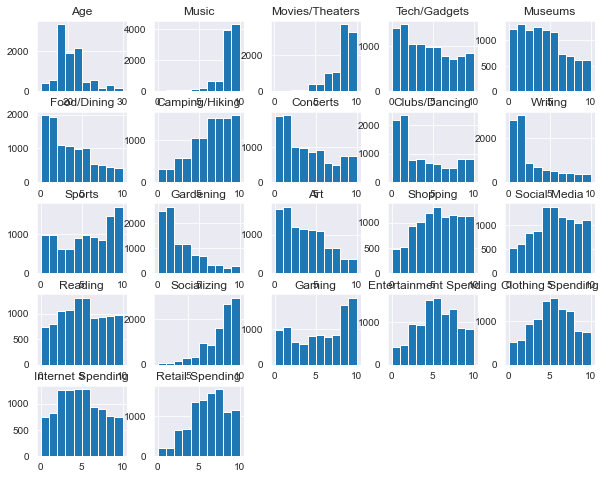

In [23]:
# plot histograms
df.hist(figsize=(10, 8))
plt.show()

In [24]:
# describe
df.describe()

,Age,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming,Entertainment Spending,Clothing Spending,Internet Spending,Retail Spending
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,20.386600,8.485650,8.221250,4.334410,4.226790,3.51436,6.339660,3.859940,3.683200,2.783220,5.552260,2.779840,3.694960,5.537580,5.471920,5.067150,8.144480,5.663800,5.422330,5.240530,4.785600,6.113950
std,2.780596,1.401132,1.488302,2.922271,2.702377,2.68117,2.471258,2.946626,3.085511,2.641601,3.074693,2.387321,2.597541,2.626148,2.617237,2.725082,1.537818,3.150193,2.438987,2.460029,2.631747,2.254891
min,15.000000,0.000000,0.100000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,8.200000,7.600000,1.700000,1.900000,1.20000,4.700000,1.300000,1.100000,0.875000,2.800000,1.000000,1.500000,3.500000,3.500000,2.900000,7.400000,2.700000,3.700000,3.400000,2.700000,4.600000
50%,20.000000,8.800000,8.600000,4.000000,4.000000,2.90000,6.700000,3.200000,2.500000,1.700000,5.900000,1.900000,3.300000,5.600000,5.500000,5.000000,8.600000,6.100000,5.400000,5.300000,4.700000,6.300000
75%,21.000000,9.400000,9.300000,6.700000,6.125000,5.40000,8.300000,6.000000,6.100000,4.200000,8.400000,4.000000,5.600000,7.700000,7.600000,7.300000,9.300000,8.600000,7.300000,7.100000,6.800000,7.800000
max,30.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


___No unusual distributions or min/ max values.___

# 1. Data cleaning

- Target audience will only include people who score greater than 5.0 on both “Clothing Spending” AND “Internet Spending”
    - reduce number of observations by masking
- Clusters to be based on demographics attributes and affinity scores toward specific interests.
    - drop irrelevant __behavioural__ features

In [25]:
# mask
mask = (df['Clothing Spending'] > 5) & (df['Internet Spending'] > 5)

# list of columns to keep
cols = list(df.columns[:-4])

# new dataframe
df_clean = (
    df
    .copy()[mask][cols]
    )

print(df_clean.shape)
df_clean.head(3)

(2889, 19)


,Age,Gender,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming
0,17.0,male,7.3,8.1,2.8,1.6,4.5,7.1,0.3,0.6,0.7,9.5,0.9,2.9,9.9,4.4,1.4,8.7,6.7
4,19.0,female,9.1,9.8,1.4,3.9,3.1,5.4,8.2,4.7,2.0,8.9,1.1,4.5,4.4,5.1,5.0,6.8,3.0
18,20.0,female,9.7,9.4,5.1,4.4,0.7,5.8,0.7,1.7,0.2,9.2,1.6,5.0,10.0,3.6,4.8,9.4,8.5


# 2. Dimensionality reduction with PCA

Capture at least 80% of the variance in our dataset with fewer input features for our clustering model.

## 2.1 Analytical base table (ABT)

In [26]:
# ABT with Gender as binary feature
abt = pd.get_dummies(df_clean, drop_first=True)

print(abt.shape)
abt.head(3)

(2889, 19)


,Age,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming,Gender_male
0,17.0,7.3,8.1,2.8,1.6,4.5,7.1,0.3,0.6,0.7,9.5,0.9,2.9,9.9,4.4,1.4,8.7,6.7,1
4,19.0,9.1,9.8,1.4,3.9,3.1,5.4,8.2,4.7,2.0,8.9,1.1,4.5,4.4,5.1,5.0,6.8,3.0,0
18,20.0,9.7,9.4,5.1,4.4,0.7,5.8,0.7,1.7,0.2,9.2,1.6,5.0,10.0,3.6,4.8,9.4,8.5,0


## 2.2 Principle Component Analysis (PCA) 

Principle Component Analysis (PCA) is a dimensionality reduction technique. PCA creates new features by finding linear combinations of the original ones. These new features called princple components are meant to maximize the 'explained variance'.

* PCA is effective when you have many correlated features
* PCA creates new features that replace the original ones

The following Principle Component Analysis determines that the first 11 PCs meet our requirement, which is at least  80% of the variance in the data set

In [27]:
# initialize PCA
pca = PCA()

# fit pca 
trained_pca = pca.fit(abt)

# save as trained_pca
print(trained_pca)

# save trained_pca for function in final step
with open('trained_pca.pkl', 'wb') as f:
    pickle.dump(trained_pca, f)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


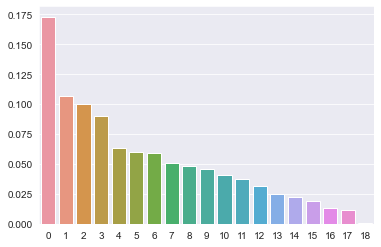

In [28]:
# plot explained variance ratio for each feature
sns.barplot(x=np.arange(pca.n_components_), 
            y=pca.explained_variance_ratio_,
           )

plt.show()

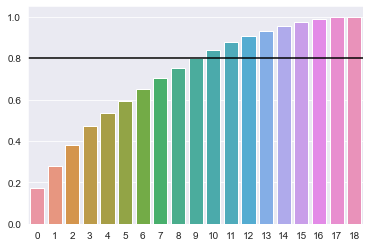

In [29]:
# plot cumulative explained variance ratio 
cumulative = np.cumsum(pca.explained_variance_ratio_)

sns.barplot(x=np.arange(pca.n_components_), 
            y=cumulative
           )
plt.axhline(y=0.8, color='k', linestyle='-')
plt.show()

In [30]:
# check cumulative values
print(cumulative[9])
print(cumulative[10])

0.798546055121548
0.839049598215688


In [31]:
# PCs to dataframe
pc_df = pd.DataFrame(pca.transform(abt))

In [32]:
# rename columns
pc_df.columns = [f'PC{n+1}' for n in np.arange(pca.n_components_)]

In [33]:
# check
pc_df.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-4.718882,-2.960997,1.116481,2.548510,-0.199757,-1.365595,-0.791734,-5.314410,2.321042,-2.127782,2.549628,-0.703628,0.477296,-2.276950,2.987285,1.136840,0.809147,0.100033,0.606076
1,0.491975,1.380983,1.128373,6.301044,-0.359154,0.709515,-1.014473,1.097250,1.166798,0.156752,1.311644,1.418522,-0.526075,0.050525,-2.956461,0.213495,-0.668280,-1.945622,-0.374975
2,-2.770408,-4.774232,1.598379,0.078869,-0.386427,-0.448358,-1.733045,-1.781863,-2.426829,-2.196854,1.731944,-2.267540,-1.811011,-1.876973,1.532407,-1.276738,-0.521122,-0.068454,-0.291319


# 3. Machine learning

## 3.1 Train k-means clustering model

In [34]:
# create training set based on 11 pcs
X_train = pc_df.iloc[:,:11]

print(X_train.shape)
X_train.tail(3)

(2889, 11)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2886,0.914349,1.579776,5.808152,4.643513,-1.711209,-0.270257,3.364896,-0.663436,-1.237748,-0.007353,0.809022
2887,-0.722841,1.149155,-3.491593,-2.519847,-1.561646,-6.392024,-2.664175,-0.331912,1.366334,1.243608,-1.337571
2888,3.080548,-3.925936,-5.692199,-1.012041,1.096192,2.367200,0.158933,-4.916887,2.779202,1.207150,-2.251944


In [35]:
# initialize KMeans for 3 clusters
kmeans = KMeans(n_clusters=3)

# fit on training set
trained_kmeans = kmeans.fit(X_train) 

# display trained_kmeans
print(trained_kmeans)

# save trained_kmeans to use as input in function
with open('trained_kmeans.pkl', 'wb') as f:
    pickle.dump(trained_kmeans, f)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=None, tol=0.0001,
       verbose=0)


## 3.2 View clusters in test set

Assign cluster to dataframe and view typical output.

In [36]:
abt['cluster'] = trained_kmeans.predict(X_train) + 1

df_clusters = (
    abt[['Age', 'cluster']]
    .copy()
    .join(df[['Gender', 'Clothing Spending', 'Internet Spending']])
)

df_clusters.head(3)

,Age,cluster,Gender,Clothing Spending,Internet Spending
0,17.0,2,male,8.6,9.5
4,19.0,1,female,5.9,5.6
18,20.0,1,female,7.2,6.2


# 4. Productionize

The objective is to write a a single function which takes 4 inputs and returns a table of 5 columns

Four inputs:

* A raw dataset with the same structure as “millennial_market_research.csv”
* A trained PCA transformer
* A trained clustering model
* The number of principal components to keep

Table output:

* Age
* Gender
* Clothing Spending
* Internet Spending
* Cluster (from the model)

## 4.1 Solution 1 (quick)
This solution contains all the steps in a single function which is not so easy to interpret or maintain.

In [37]:
def cluster_millenials(raw_data, trained_pca, cluster_model, n_pcs):
    """
    Inputs

    A raw dataset with the same structure as “millennial_market_research.csv”
    A trained PCA transformer
    A trained clustering model
    The number of principal components to keep
    
    Output

    Age
    Gender
    Clothing Spending
    Internet Spending
    Cluster (from the model)
    """
    # data cleaning
    df = pd.read_csv(raw_data)
    df = df[(df['Internet Spending'] > 5) & (df['Clothing Spending'] > 5)]
    
    # feature engineering
    col_behavioural = ['Entertainment Spending', 'Clothing Spending', 'Internet Spending', 'Retail Spending']
    abt = df.drop(columns=col_behavioural)
    abt = pd.get_dummies(abt, drop_first=True)
    
    # pca transformer
    pc_df = pd.DataFrame(trained_pca.transform(abt))
    pc_df.columns = [f'PC{n+1}' for n in np.arange(trained_pca.n_components_)]
    pc_df = pc_df.iloc[:,:n_pcs]
    
    # prediction
    df['Cluster'] = cluster_model.predict(pc_df) + 1
    
    
    return df[['Age', 'Gender', 'Clothing Spending', 'Internet Spending', 'Cluster']]


In [39]:
# set input parameters
raw_data = 'unseen_raw_data.csv'
trained_pca = pickle.load(open('trained_pca.pkl', 'rb'))
cluster_model = pickle.load(open('trained_kmeans.pkl', 'rb'))
n_pcs = 11

# execute 
cluster_millenials(raw_data, trained_pca, cluster_model, n_pcs)

,Age,Gender,Clothing Spending,Internet Spending,Cluster
0,21.0,female,7.8,5.7,1
11,20.0,male,5.3,6.7,1
17,18.0,female,8.4,5.9,1
21,28.0,female,7.4,7.3,3
26,18.0,male,5.4,5.1,2
28,22.0,female,6.4,6.7,3
29,19.0,male,6.0,8.9,2
33,30.0,male,6.3,6.1,3
47,26.0,male,7.5,7.1,3
48,23.0,female,7.2,6.0,1


## 4.2 Solution 2
This solution consists of multiple smaller, easy to interpret functions. I believe this is a better solution to deploy in a real-world scenario.

### 4.2.1 Shaping the unseen data

In [40]:
def load_unseen(raw_data='unseen_raw_data.csv', usecols=None):
    """
    takes csv as input 
    returns dataframe
    optional usecols argument allows for reduced set when preparing final data set
    """
    return pd.read_csv(raw_data, usecols=usecols)

In [41]:
def data_cleaning(df):
    """
    takes dataframe
    returns dataframe with reduction by condition on 'spending' features
    """
    return df[(df['Internet Spending'] > 5) & (df['Clothing Spending'] > 5)]

In [42]:

def feature_engineering(df):
    """
    takes dataframe
    returns dataframe excluding irrelevant behavour features and including gender indicator
    """
    col_behavioural = ['Entertainment Spending', 'Clothing Spending', 'Internet Spending', 'Retail Spending']
    df.drop(columns=col_behavioural, inplace=True)
    return pd.get_dummies(df, drop_first=True)
    

In [43]:
# pipe that generates abt dataframe
abt = (
    load_unseen()
    .pipe(data_cleaning)
    .pipe(feature_engineering)
)

print(abt.shape)
abt.head(3)

(11, 19)


,Age,Music,Movies/Theaters,Tech/Gadgets,Museums,Food/Dining,Camping/Hiking,Concerts,Clubs/Dancing,Writing,Sports,Gardening,Art,Shopping,Social Media,Reading,Socializing,Gaming,Gender_male
0,21.0,9.5,7.2,0.8,3.5,3.8,9.1,0.8,1.0,0.1,7.0,5.8,5.8,4.2,5.7,4.7,7.8,8.8,0
11,20.0,9.9,9.8,6.9,6.4,1.0,7.5,4.6,1.9,0.7,8.4,0.6,3.4,5.1,1.8,1.8,6.2,8.4,1
17,18.0,8.3,9.0,3.0,6.1,0.9,8.2,3.4,8.4,0.2,5.1,1.9,0.3,8.5,9.1,8.1,9.8,9.0,0


### 4.2.2 Transform the ABT

In [44]:
def pca_transformer(abt, trained_pca=trained_pca, n_pcs=11):
    """
    takes analytical base table, a trained pca transformer, and the number of principal components
    returns a dataframe to be used to train a clustering algo
    """
    pc_df = pd.DataFrame(pca.transform(abt))
    pc_df.columns = [f'PC{n+1}' for n in np.arange(pca.n_components_)]
    return pc_df.iloc[:,:n_pcs]
    

In [45]:
# generate principal component dataframe as model input
pc_df = pca_transformer(abt, trained_pca=trained_pca, n_pcs=11)
pc_df.head(3)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-0.785581,-1.106090,1.048387,-1.811471,-1.004953,1.904800,-2.849078,-5.312605,2.179084,1.176230,1.747108
1,-2.347836,-3.125780,-0.432883,1.815301,-2.969808,0.271902,-2.009847,0.212563,-0.701636,-2.946220,-3.336611
2,2.492371,0.912783,2.722441,-2.344242,-6.074743,-2.998997,1.141905,1.398552,-0.285788,0.187128,4.952064


### 4.2.3 Predict the cluster

In [51]:
def add_cluster(df, model=trained_kmeans, features=pc_df):
    """
    Takes
    1. a cleaned unseen dataframe to present output, 
    2. a transformed dataframe containing the PCA features, 
    3. a trained kmeans clustering model
    
    Outputs a dataframe containing the cluster and the specified columns
    """
    df['cluster'] = model.predict(features) + 1
    return df

In [52]:
# pipe to generate required result set including cluster
result_df = (
    load_unseen(usecols=['Age', 'Gender', 'Clothing Spending', 'Internet Spending'])
    .pipe(data_cleaning)
    .pipe(add_cluster, model=trained_kmeans, features=pc_df)
)

result_df.head(20)

,Age,Gender,Clothing Spending,Internet Spending,cluster
0,21.0,female,7.8,5.7,1
11,20.0,male,5.3,6.7,1
17,18.0,female,8.4,5.9,1
21,28.0,female,7.4,7.3,3
26,18.0,male,5.4,5.1,2
28,22.0,female,6.4,6.7,3
29,19.0,male,6.0,8.9,2
33,30.0,male,6.3,6.1,3
47,26.0,male,7.5,7.1,3
48,23.0,female,7.2,6.0,1
